In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
from skimage import io
from skimage import data
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


1.11.0
2.1.3


In [2]:
print("loading data")
x_train = pd.read_csv("data/emnist-letters-train.csv")
x_test = pd.read_csv("data/emnist-letters-test.csv")
x_train = x_train.values
x_test = x_test.values

loading data


In [3]:
print("training_size:")
print(x_train.shape)
print("test_size")
print(x_test.shape)

training_size:
(88799, 785)
test_size
(14799, 785)


In [4]:
print("Seperating first column from the x")
y_train = x_train[:,:1]
y_train = np.array(list(map(lambda x: x-1, y_train.flatten())))
x_train = x_train[:,1:]
y_test = x_test[:,:1]
y_test = np.array(list(map(lambda x: x-1, y_test.flatten())))
x_test = x_test[:,1:]

Seperating first column from the x


In [5]:
print("transposing data:")
x_train = np.array(list(map(lambda x: x.reshape(28,28).transpose() ,x_train)))
x_test = np.array(list(map(lambda x: x.reshape(28,28).transpose() ,x_test)))
print("done")

transposing data:
done


In [6]:
print("reshaping data:")
#for CNN
x_train = np.array(list(map(lambda x: x.reshape(28,28,1) ,x_train)))
x_test = np.array(list(map(lambda x: x.reshape(28,28,1) ,x_test)))

reshaping data:


In [7]:
num_classes = 26

In [8]:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

88799 train samples
14799 test samples


In [9]:
def make_model():
#    Define your model architecture here.
#   Returns `Sequential` model.

    model = Sequential()
    model.add(Conv2D(16,(3,3),input_shape = (28,28,1)))
    model.add(LeakyReLU(0.1))
    #model.add(Activation)
    model.add(Conv2D(32,(3,3)))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64,(3,3)))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dropout(0.25))
    model.add(LeakyReLU(0.1)) 
    model.add(Dense(num_classes, activation = 'softmax'))
    return model

In [10]:
tf.reset_default_graph()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
__________

In [11]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 256
EPOCHS = 10

tf.reset_default_graph()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

In [12]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'models/letters.{0:03d}.hdf5'
last_finished_epoch = None

In [13]:
# fit model
model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory()],
               #TQDMCallback()] ,
               #keras.utils.TqdmProgressCallback(),
               #keras.utils.ModelSaveCallback(model_filename)],
    validation_split=0.1,
    shuffle=True,
    verbose=1,
    initial_epoch=last_finished_epoch or 0
)

Train on 79919 samples, validate on 8880 samples
Learning rate: 0.005
Epoch 1/10
79919/79919 [==============================] - 174s 2ms/step - loss: 0.6557 - acc: 0.7969 - val_loss: 0.2902 - val_acc: 0.9081
Learning rate: 0.0045
Epoch 2/10
79919/79919 [==============================] - 130s 2ms/step - loss: 0.3117 - acc: 0.8974 - val_loss: 0.2303 - val_acc: 0.9251
Learning rate: 0.00405
Epoch 3/10
79919/79919 [==============================] - 129s 2ms/step - loss: 0.2550 - acc: 0.9150 - val_loss: 0.2144 - val_acc: 0.9328
Learning rate: 0.003645
Epoch 4/10
79919/79919 [==============================] - 130s 2ms/step - loss: 0.2248 - acc: 0.9236 - val_loss: 0.2052 - val_acc: 0.9333
Learning rate: 0.0032805
Epoch 5/10
79919/79919 [==============================] - 135s 2ms/step - loss: 0.2054 - acc: 0.9295 - val_loss: 0.1970 - val_acc: 0.9377
Learning rate: 0.00295245
Epoch 6/10
79919/79919 [==============================] - 154s 2ms/step - loss: 0.1901 - acc: 0.9332 - val_loss: 0.1886 

In [14]:
model.save_weights("cnn_weights.h5")
model.save("cnn_model.h5")

In [15]:
# make test predictions
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)


In [16]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.20726496460873672
Test accuracy: 0.9307385634204747


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

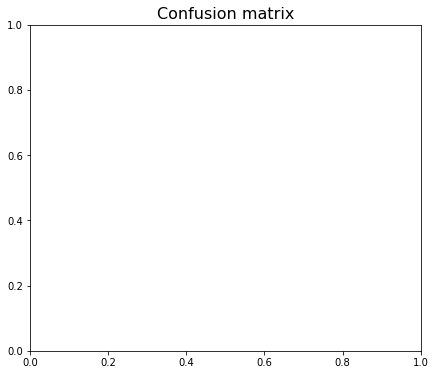

In [17]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(20), 20, rotation=45, fontsize=12)
plt.yticks(np.arange(20), 20, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))